In [1]:
#Standard libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes =True)
sns.set_theme(style="whitegrid")


In [2]:
#2. Imports & Configuration (Code Cell)

# Optional automated profiling
from ydata_profiling import ProfileReport
import sweetviz as sv

# Plotly for interactive charts
import plotly.express as px

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


In [3]:
df_cleaned = pd.read_excel(r"C:\Users\HP\Downloads\Online Retail.xlsx")

In [4]:
print(df_cleaned.info())      # Overview of columns and data types , miss counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [5]:
df_cleaned.describe(include = "all") # for summary statistics

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.00,541909,540455,541909.00,541909,541909.00,406829.00,541909
unique,25900.00,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.00,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.55,2011-07-04 13:34:57.156386048,4.61,15287.69,NaN
min,NaN,NaN,NaN,-80995.00,2010-12-01 08:26:00,-11062.06,12346.00,NaN
25%,NaN,NaN,NaN,1.00,2011-03-28 11:34:00,1.25,13953.00,NaN
50%,NaN,NaN,NaN,3.00,2011-07-19 17:17:00,2.08,15152.00,NaN
75%,NaN,NaN,NaN,10.00,2011-10-19 11:27:00,4.13,16791.00,NaN
max,NaN,NaN,NaN,80995.00,2011-12-09 12:50:00,38970.00,18287.00,NaN


Cleaning Steps
Remove exact duplicates

In [6]:
# remove exact duplicate rows
df_cleaned = df_cleaned.drop_duplicates()


Handle missing CustomerID and Description

CustomerID: fill with a placeholder or drop, depending on downstream needs.

Description: drop rows where this is missing, since item name is critical.

In [7]:
#Inspect and Handle Missing Values
#Check how many rows lack descriptions or CustomerIDs:

desc_nulls = df_cleaned['Description'].isnull().sum()
cust_nulls = df_cleaned['CustomerID'].isnull().sum()
print(f"Missing Descriptions: {desc_nulls}")
print(f"Missing CustomerIDs: {cust_nulls}")


Missing Descriptions: 1454
Missing CustomerIDs: 135037


In [8]:
# Before exclusion
print("Original rows:", df_cleaned.shape[0])

# Drop rows with null CustomerID
df_no_missing_cust = df_cleaned.dropna(subset=['CustomerID']).copy()

print("After dropping missing CustomerID:", df_no_missing_cust.shape[0])


Original rows: 536641
After dropping missing CustomerID: 401604


In [9]:
# Calculate mode of CustomerID
cust_mode = df_cleaned['CustomerID'].mode()[0]
print("CustomerID mode:", cust_mode)

# Impute missing CustomerID with mode
df_imputed_cust = df_cleaned.copy()
df_imputed_cust['CustomerID'].fillna(cust_mode, inplace=True)

# Verify no more nulls
print("Nulls after imputation:",
      df_imputed_cust['CustomerID'].isna().sum())


CustomerID mode: 17841.0
Nulls after imputation: 0


C:\Users\HP\AppData\Local\Temp\ipykernel_4068\258774323.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed_cust['CustomerID'].fillna(cust_mode, inplace=True)


Drop any row lacking a product description, which may correspond to incomplete transaction details.

In [10]:
# Before exclusion
print("Original rows:", df_cleaned.shape[0])

# Drop rows with null Description
df_no_missing_desc = df_cleaned.dropna(subset=['Description']).copy()

print("After dropping missing Description:", df_no_missing_desc.shape[0])


Original rows: 536641
After dropping missing Description: 535187


In [11]:
# Simple fill with placeholder
df_imputed_desc = df_cleaned.copy()
df_imputed_desc['Description'].fillna('Unknown Description', inplace=True)

# Or, forward-fill descriptions within each StockCode group
df_ffill_desc = df_cleaned.sort_values(['StockCode', 'InvoiceDate']).copy()
df_ffill_desc['Description'] = (
    df_ffill_desc
    .groupby('StockCode')['Description']
    .ffill()
    .bfill()
)

# Check remaining missing
print("Placeholder fill missing:",
      df_imputed_desc['Description'].isna().sum())
print("Group fill missing:",
      df_ffill_desc['Description'].isna().sum())


C:\Users\HP\AppData\Local\Temp\ipykernel_4068\2572302375.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed_desc['Description'].fillna('Unknown Description', inplace=True)


Placeholder fill missing: 0
Group fill missing: 0


In [12]:
df_cleaned= df_cleaned.dropna(subset=['Description'])
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].fillna(0).astype(int)



Convert data types

In [13]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df_cleaned['InvoiceNo']   = df_cleaned['InvoiceNo'].astype(str)
df_cleaned['StockCode']   = df_cleaned['StockCode'].astype(str)


#Here’s how to count cancellations and returns

In [14]:
# 1. Flag cancellations and returns
df_cleaned['IsCancellation'] = (
    df_cleaned['InvoiceNo']
      .astype(str)
      .str.upper()
      .str.startswith('C')
)
df_cleaned['IsReturn'] = df_cleaned['Quantity'] < 0



In [15]:
# 2. Compute the totals
num_cancel_rows     = df_cleaned['IsCancellation'].sum()
num_return_rows     = df_cleaned['IsReturn'].sum()
num_cancel_invoices = df_cleaned.loc[df_cleaned['IsCancellation'], 'InvoiceNo'].nunique()
num_return_invoices = df_cleaned.loc[df_cleaned['IsReturn'],       'InvoiceNo'].nunique()

print(f"Cancellation transactions:      {num_cancel_rows}")
print(f"Unique cancelled invoices:     {num_cancel_invoices}")
print(f"Return transactions (neg Qty): {num_return_rows}")
print(f"Unique return invoices:        {num_return_invoices}")



Cancellation transactions:      9251
Unique cancelled invoices:     3836
Return transactions (neg Qty): 9725
Unique return invoices:        4310


In [16]:
df_cleaned['Is_Return'] = df_cleaned['InvoiceNo'].str.startswith('C', na=False)


In [17]:
df_cleaned[df_cleaned['Is_Return']]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancellation,IsReturn,Is_Return
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True,True,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True,True,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True,True,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True,True,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,True,True,True
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,True,True,True
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,True,True,True
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,True,True,True


Flag and remove cancels/returns

Cancellations: InvoiceNo starts with "C"

Returns: negative Quantity

In [18]:
df_cleaned['IsCancelled'] = df_cleaned['InvoiceNo'].str.startswith('C')
df_cleaned['IsReturn']    = df_cleaned['Quantity'] < 0
df_cleaned = df_cleaned[~df_cleaned['IsCancelled']]  # drop cancels


 count rows where a field is ≤ 0 (i.e. “less than or equal to zero”). I’ll show both UnitPrice and Quantity:



In [19]:
# Count non-positive unit prices
non_pos_price_mask = df_cleaned['UnitPrice'] <= 0
num_non_pos_price = non_pos_price_mask.sum()
print(f"Rows with UnitPrice ≤ 0: {num_non_pos_price}")


Rows with UnitPrice ≤ 0: 1058


In [20]:
# Count negative quantities (returns)
neg_qty_mask = df_cleaned['Quantity'] < 0
num_neg_qty = neg_qty_mask.sum()
print(f"Rows with Quantity < 0: {num_neg_qty}")


Rows with Quantity < 0: 474


Audit and Understand Identify context

Are zero‐priced lines genuine promotions or data entry errors?

Are negative quantities always returns/cancellations or occasional corrections?

In [21]:
#Examine extreme values

df_cleaned[df_cleaned['UnitPrice'] <= 0].describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,1058.00,1058,1058.00,1058.00
mean,-114.13,2011-06-28 01:52:12.646502912,-20.91,537.51
min,-9600.00,2010-12-03 12:08:00,-11062.06,0.00
25%,-57.00,2011-03-11 16:21:45,0.00,0.00
50%,1.00,2011-06-28 14:01:00,0.00,0.00
75%,2.00,2011-10-28 09:58:15,0.00,0.00
max,12540.00,2011-12-08 15:24:00,0.00,18059.00
std,778.71,NaN,480.73,2731.97


In [22]:
df_cleaned[df_cleaned['Quantity'] < 0].groupby(df_cleaned['InvoiceNo'].str.startswith('C')).size()


InvoiceNo
False    474
dtype: int64

in quantity there is typo error of 474

Remove zero or negative unit prices

In [23]:
df_cleaned= df_cleaned[df_cleaned['UnitPrice'] > 0]


Feature Engineering & Transformation

In [24]:
#Compute total transaction value
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']


In [25]:
#Extract temporal features

df_cleaned['Year']  = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day']   = df_cleaned['InvoiceDate'].dt.day
df_cleaned['Hour']  = df_cleaned['InvoiceDate'].dt.hour


Flag promotions or outliers

Outlier quantity: beyond 99th percentile

Outlier price: beyond 99th percentile

In [26]:
q_upper = df_cleaned['Quantity'].quantile(0.99)
p_upper = df_cleaned['UnitPrice'].quantile(0.99)

df_cleaned['Qty_Outlier']   = df_cleaned['Quantity'] > q_upper
df_cleaned['Price_Outlier'] = df_cleaned['UnitPrice'] > p_upper


Clean country names (optional)

In [27]:
df_cleaned['Country'] = df_cleaned['Country'].str.strip().str.title()


In [28]:
df_cleaned['Description'] = df_cleaned['Description'].str.strip()

In [29]:
# If there are other text columns, e.g., InvoiceNo or StockCode, strip them too:
df_cleaned['InvoiceNo'] = df_cleaned['InvoiceNo'].str.strip()
df_cleaned['StockCode'] = df_cleaned['StockCode'].str.strip()


Final Checkpoint
Inspect the cleaned dataframe and export if needed:

In [30]:
print(df_cleaned.info())
print(df_cleaned.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Index: 524878 entries, 0 to 541908
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       524878 non-null  object        
 1   StockCode       524878 non-null  object        
 2   Description     524878 non-null  object        
 3   Quantity        524878 non-null  int64         
 4   InvoiceDate     524878 non-null  datetime64[ns]
 5   UnitPrice       524878 non-null  float64       
 6   CustomerID      524878 non-null  int32         
 7   Country         524878 non-null  object        
 8   IsCancellation  524878 non-null  bool          
 9   IsReturn        524878 non-null  bool          
 10  Is_Return       524878 non-null  bool          
 11  IsCancelled     524878 non-null  bool          
 12  TotalPrice      524878 non-null  float64       
 13  Year            524878 non-null  int32         
 14  Month           524878 non-null  int32   

In [31]:

# Optional: save to new file
df_cleaned.to_csv("Online_Retail_Cleaned.csv", index=False)


exploratory data analysis (EDA) on "Online Retail.xlsx" file

In [32]:
df_cleaned.describe(include='all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancellation,IsReturn,Is_Return,IsCancelled,TotalPrice,Year,Month,Day,Hour,Qty_Outlier,Price_Outlier
count,524878,524878,524878,524878.00,524878,524878.00,524878.00,524878,524878,524878,524878,524878,524878.00,524878.00,524878.00,524878.00,524878.00,524878,524878
unique,19960,3922,4015,NaN,NaN,NaN,NaN,38,1,1,1,1,NaN,NaN,NaN,NaN,NaN,2,2
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,False
freq,1114,2253,2311,NaN,NaN,NaN,NaN,479985,524878,524878,524878,524878,NaN,NaN,NaN,NaN,NaN,520031,519804
mean,NaN,NaN,NaN,10.62,2011-07-04 15:30:16.317049088,3.92,11437.73,NaN,NaN,NaN,NaN,NaN,20.28,2010.92,7.55,15.02,13.07,NaN,NaN
min,NaN,NaN,NaN,1.00,2010-12-01 08:26:00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,0.00,2010.00,1.00,1.00,6.00,NaN,NaN
25%,NaN,NaN,NaN,1.00,2011-03-28 12:13:00,1.25,0.00,NaN,NaN,NaN,NaN,NaN,3.90,2011.00,5.00,7.00,11.00,NaN,NaN
50%,NaN,NaN,NaN,4.00,2011-07-20 11:22:00,2.08,14350.00,NaN,NaN,NaN,NaN,NaN,9.92,2011.00,8.00,15.00,13.00,NaN,NaN
75%,NaN,NaN,NaN,11.00,2011-10-19 11:41:00,4.13,16245.00,NaN,NaN,NaN,NaN,NaN,17.70,2011.00,11.00,22.00,15.00,NaN,NaN
max,NaN,NaN,NaN,80995.00,2011-12-09 12:50:00,13541.33,18287.00,NaN,NaN,NaN,NaN,NaN,168469.60,2011.00,12.00,31.00,20.00,NaN,NaN


<Axes: xlabel='UnitPrice', ylabel='Count'>

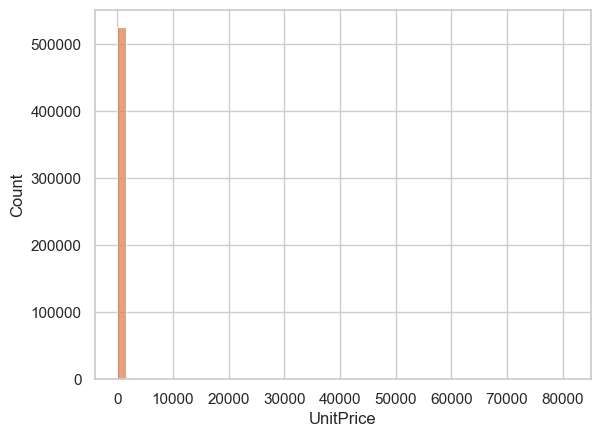

In [33]:
sns.histplot(df_cleaned['UnitPrice'], bins=50)
sns.histplot(df_cleaned['Quantity'], bins=50)


<Axes: xlabel='InvoiceDate'>

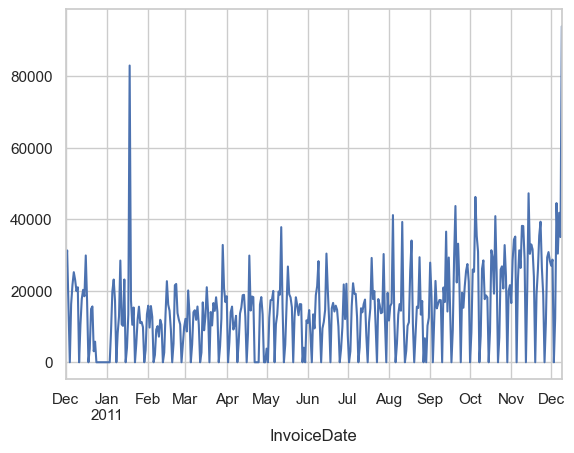

In [34]:
#Explore purchasing patterns over time:

df_cleaned.set_index('InvoiceDate').resample('D').sum()['Quantity'].plot()


<Axes: ylabel='Description'>

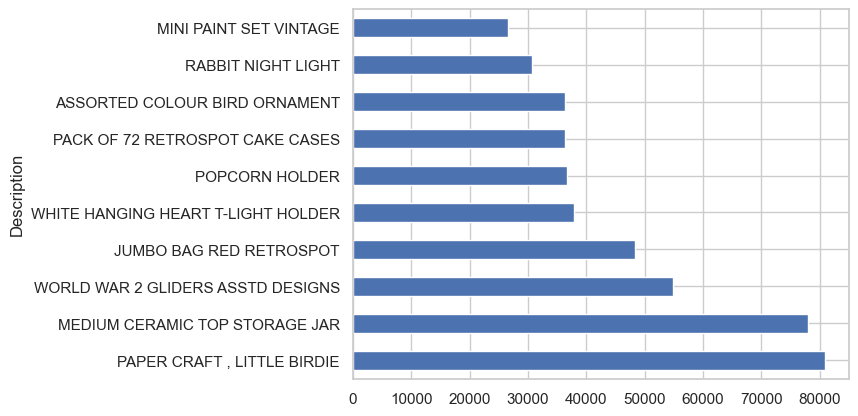

In [35]:
#Top-selling products:

top_products = df_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh')


<Axes: xlabel='Country'>

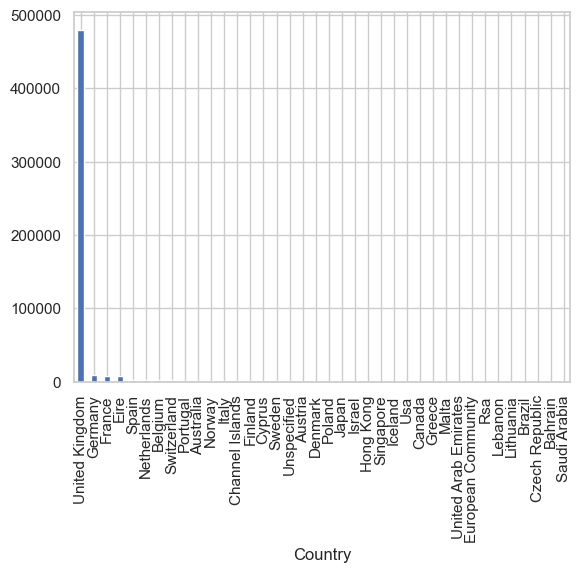

In [36]:
#Customer Segmentation
#Find out where the customers are and how they behave:
df_cleaned['Country'].value_counts().plot(kind='bar')


In [37]:
sv.analyze(df_cleaned).show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [39]:
snapshot_date = df_rfm_prep['InvoiceDate'].max() + pd.Timedelta(days=1)


In [45]:
#Compute RFM Metrics

rfm = df_rfm_prep.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo':    'nunique',
    'Quantity':     lambda x: (x * df_rfm_prep.loc[x.index, 'UnitPrice']).sum()
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo':   'Frequency',
    'Quantity':    'Monetary'
})


Performing RFM Analysis Step by Step
Below is a complete walkthrough—using your df_cleaned DataFrame—to calculate Recency, Frequency, and Monetary values, assign RFM scores (1–5), and label customer segments.

In [47]:
import pandas as pd
from datetime import timedelta

# 1.1 Filter out returns/cancellations and missing customers
df= df_cleaned.copy()
df = df[df['Quantity'] > 0]                     # drop negative or zero quantities
df = df[df['UnitPrice'] > 0]                    # drop free or negative‐priced items
df = df.dropna(subset=['CustomerID'])           # ensure every row has a CustomerID

# 1.2 Calculate total spend per line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


Compute RFM Metrics

In [48]:
# 2.1 Reference date (one day after last invoice in data)
reference_date = df['InvoiceDate'].max() + timedelta(days=1)


In [49]:
# 2.2 Recency: days since last purchase
recency = (
    df.groupby('CustomerID')['InvoiceDate']
      .max()
      .reset_index()
      .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
recency['Recency'] = (reference_date - recency['LastPurchaseDate']).dt.days



In [50]:
# 2.3 Frequency: count of unique invoices
frequency = (
    df.groupby('CustomerID')['InvoiceNo']
      .nunique()
      .reset_index()
      .rename(columns={'InvoiceNo': 'Frequency'})
)


In [51]:
# 2.4 Monetary: total spend per customer
monetary = (
    df.groupby('CustomerID')['TotalPrice']
      .sum()
      .reset_index()
      .rename(columns={'TotalPrice': 'Monetary'})
)



In [52]:
# 2.5 Merge into one RFM table
rfm = recency.merge(frequency, on='CustomerID') \
             .merge(monetary, on='CustomerID')


Assign RFM Scores (1 = worst, 5 = best)

In [53]:
# 3.1 Recency score (inverse: lower recency → higher score)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)


In [54]:
# 1. Compute percentile rank for each Frequency
rfm['FreqRankPct'] = rfm['Frequency'].rank(pct=True)

# 2. Bin into five equal percentile groups
rfm['F_Score'] = pd.cut(
    rfm['FreqRankPct'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=[1, 2, 3, 4, 5]
).astype(int)

# 3. Drop helper column if you like
rfm.drop(columns=['FreqRankPct'], inplace=True)


This approach always creates exactly five bins because it’s based on the unique rank percentiles.

In [55]:
# 3.3 Monetary score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)


In [56]:
# 3.4 Combined RFM string
rfm['RFM_Score'] = (
    rfm['R_Score'].map(str) +
    rfm['F_Score'].map(str) +
    rfm['M_Score'].map(str)
)


Define Customer Segments

In [57]:
# A simple mapping from RFM score prefixes to segment names
segment_map = {
    r'[5][5]': 'Champions',
    r'[4-5][3-5]': 'Loyal Customers',
    r'[3-4][1-2]': 'Potential Loyalists',
    r'[2-3][4-5]': 'At Risk',
    r'[1-2][1-2]': 'Lost'
}

def assign_segment(row):
    rf = f"{row['R_Score']}{row['F_Score']}"
    for pattern, seg in segment_map.items():
        if pd.Series(rf).str.contains(pattern, regex=True).bool():
            return seg
    return 'Others'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

# View the top rows
display(rfm.sort_values('RFM_Score', ascending=False).head())


C:\Users\HP\AppData\Local\Temp\ipykernel_4068\3597596363.py:13: FutureWarning: Series.bool is now deprecated and will be removed in future version of pandas
  if pd.Series(rf).str.contains(pattern, regex=True).bool():


,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,0,2011-12-09 10:26:00,1,1428,1754901.91,5,5,5,555,Champions
3533,17173,2011-12-04 14:40:00,5,8,3766.60,5,5,5,555,Champions
3344,16905,2011-12-04 14:01:00,5,7,3037.60,5,5,5,555,Champions
3343,16904,2011-12-05 13:10:00,4,16,3653.75,5,5,5,555,Champions
3321,16873,2011-12-05 12:05:00,5,6,7123.62,5,5,5,555,Champions


In [58]:
print(rfm.columns.tolist())


['CustomerID', 'LastPurchaseDate', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']


In [59]:
rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str)
    + rfm['F_Score'].astype(str)
    + rfm['M_Score'].astype(str)
)


In [60]:
rfm[['CustomerID','R_Score','F_Score','M_Score','RFM_Segment']].head()


,CustomerID,R_Score,F_Score,M_Score,RFM_Segment
0,0,5,5,5,555
1,12346,1,1,5,115
2,12347,5,5,5,555
3,12348,2,4,4,244
4,12349,4,1,4,414


In [61]:
# 1.1 Extract unique SKUs + descriptions
products = (
    df_cleaned[['StockCode','Description']]
      .drop_duplicates()
      .reset_index(drop=True)
)

# 1.2 Define your mapping function
def map_category(desc):
    d = desc.upper()
    if 'MUG' in d or 'CUP' in d:
        return 'Kitchenware'
    if 'CARD' in d or 'BOOK' in d:
        return 'Stationery & Books'
    if 'TOY' in d or 'FIGURINE' in d:
        return 'Toys & Gifts'
    return 'Other'

# 1.3 Apply to get the Category column
products['Category'] = products['Description'].fillna('').apply(map_category)

# 1.4 Quick check
print(products.head())


  StockCode                          Description     Category
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER        Other
1     71053                  WHITE METAL LANTERN        Other
2    84406B       CREAM CUPID HEARTS COAT HANGER  Kitchenware
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE        Other
4    84029E       RED WOOLLY HOTTIE WHITE HEART.        Other


In [62]:
df_rfm_trans = (
    df_cleaned
      .merge(
          rfm[['CustomerID','RFM_Segment']],
          on='CustomerID',
          how='left'
      )
      .merge(
          products[['StockCode','Category']],
          on='StockCode',
          how='left'
      )
)

# Verify the merge
print(df_rfm_trans[['CustomerID','RFM_Segment','StockCode','Category']].head())


   CustomerID RFM_Segment StockCode     Category
0       17850         155    85123A        Other
1       17850         155    85123A        Other
2       17850         155     71053        Other
3       17850         155     71053        Other
4       17850         155    84406B  Kitchenware


In [63]:
segment_category = (
    df_rfm_trans
      .groupby(['RFM_Segment','Category'])
      .agg(
          Total_Spent=('Quantity','sum'),
          Unique_Customers=('CustomerID','nunique')
      )
      .reset_index()
)

segment_category['Pct_Spend'] = (
    segment_category
      .groupby('RFM_Segment')['Total_Spent']
      .transform(lambda x: x / x.sum() * 100)
)

print(segment_category.head())


  RFM_Segment            Category  Total_Spent  Unique_Customers  Pct_Spend
0         111         Kitchenware          862                67       2.94
1         111               Other        27340               331      93.12
2         111  Stationery & Books         1079                71       3.68
3         111        Toys & Gifts           78                16       0.27
4         112         Kitchenware         1668                85       3.99


In [64]:
df_rfm_trans = (
    df_cleaned
      .merge(
          rfm[['CustomerID','RFM_Segment']],
          on='CustomerID',
          how='left'
      )
      .merge(
          products[['StockCode','Category']],
          on='StockCode',
          how='left'
      )
)


In [65]:
segment_category['Pct_Spend'] = (
    segment_category
      .groupby('RFM_Segment')['Total_Spent']
      .transform(lambda x: x / x.sum() * 100)
)


In [66]:
print(df_rfm_trans.columns.tolist())
# or
print(segment_category.columns)


['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'IsCancellation', 'IsReturn', 'Is_Return', 'IsCancelled', 'TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Qty_Outlier', 'Price_Outlier', 'RFM_Segment', 'Category']
Index(['RFM_Segment', 'Category', 'Total_Spent', 'Unique_Customers',
       'Pct_Spend'],
      dtype='object')


In [67]:
# Count customers per segment & country
country_profile = (
    df_rfm_trans
      .drop_duplicates(['CustomerID','RFM_Segment','Country'])
      .groupby(['RFM_Segment','Country'])
      .size()
      .reset_index(name='Cust_Count')
)

# Compute % of segment
country_profile['Pct_of_Segment'] = (
    country_profile
      .groupby('RFM_Segment')['Cust_Count']
      .transform(lambda x: x / x.sum() * 100)
)


In [68]:
# 1. Get distinct StockCode + Description
products = (
    df_cleaned[['StockCode','Description']]
    .drop_duplicates()
    .reset_index(drop=True)
)

# 2. Define a mapping function
def map_category(desc):
    d = desc.upper()
    if 'MUG' in d or 'CUP' in d:
        return 'Kitchenware'
    if 'CARD' in d or 'BOOK' in d:
        return 'Stationery & Books'
    if 'TOY' in d or 'FIGURINE' in d:
        return 'Toys & Gifts'
    # add more rules as needed
    return 'Other'

# 3. Apply to create a Category column
products['Category'] = products['Description'].fillna('').apply(map_category)

# 4. Quick check
products.Category.value_counts().head()



Category
Other                 3783
Stationery & Books     222
Kitchenware            133
Toys & Gifts            20
Name: count, dtype: int64

In [69]:
# If you haven’t already, derive a product→category map
products = (
    df_cleaned[['StockCode','Description']]
    .drop_duplicates()
    .reset_index(drop=True)
)

def map_category(desc):
    d = desc.upper()
    if 'MUG' in d or 'CUP' in d:
        return 'Kitchenware'
    if 'CARD' in d or 'BOOK' in d:
        return 'Stationery & Books'
    if 'TOY' in d or 'FIGURINE' in d:
        return 'Toys & Gifts'
    return 'Other'

products['Category'] = products['Description'].fillna('').apply(map_category)


In [70]:
# Assume:
# df_cleaned has all transactions
# rfm has CustomerID → RFM_Segment
# products has StockCode → Category

df_rfm_trans = (
    df_cleaned
      .merge(
          rfm[['CustomerID','RFM_Segment']],
          on='CustomerID',
          how='left'
      )
      .merge(
          products[['StockCode','Category']],
          on='StockCode',
          how='left'
      )
)

# Check the merge
print(df_rfm_trans[['CustomerID','RFM_Segment','StockCode','Category']].head())


   CustomerID RFM_Segment StockCode     Category
0       17850         155    85123A        Other
1       17850         155    85123A        Other
2       17850         155     71053        Other
3       17850         155     71053        Other
4       17850         155    84406B  Kitchenware


In [71]:
segment_category = (
    df_rfm_trans
      .groupby(['RFM_Segment','Category'])
      .agg(
          Total_Spent=('Quantity','sum'),            # or use LineMonetary if defined
          Unique_Customers=('CustomerID','nunique')
      )
      .reset_index()
)


Profiling RFM Segments by Country, Product Category, and Demographics
Once you’ve assigned each customer to an RFM segment, the next step is to understand who they are, what they buy, and where they live. Here’s a structured approach:

In [72]:
#Calculate Percent of Spend per Segment

segment_category['Pct_Spend'] = (
    segment_category
      .groupby('RFM_Segment')['Total_Spent']
      .transform(lambda x: x / x.sum() * 100)
)


In [73]:
#Inspect or Visualize Your Results

# Quick look at top categories for each segment
print(
    segment_category
      .sort_values(['RFM_Segment','Pct_Spend'], ascending=[True, False])
      .groupby('RFM_Segment')
      .head(5)
)


    RFM_Segment            Category  Total_Spent  Unique_Customers  Pct_Spend
1           111               Other        27340               331      93.12
2           111  Stationery & Books         1079                71       3.68
0           111         Kitchenware          862                67       2.94
3           111        Toys & Gifts           78                16       0.27
5           112               Other        38098               207      91.13
..          ...                 ...          ...               ...        ...
329         554        Toys & Gifts          146                20       0.16
331         555               Other      2665777               348      91.46
332         555  Stationery & Books       135337               305       4.64
330         555         Kitchenware       103216               306       3.54
333         555        Toys & Gifts        10466               144       0.36

[334 rows x 5 columns]


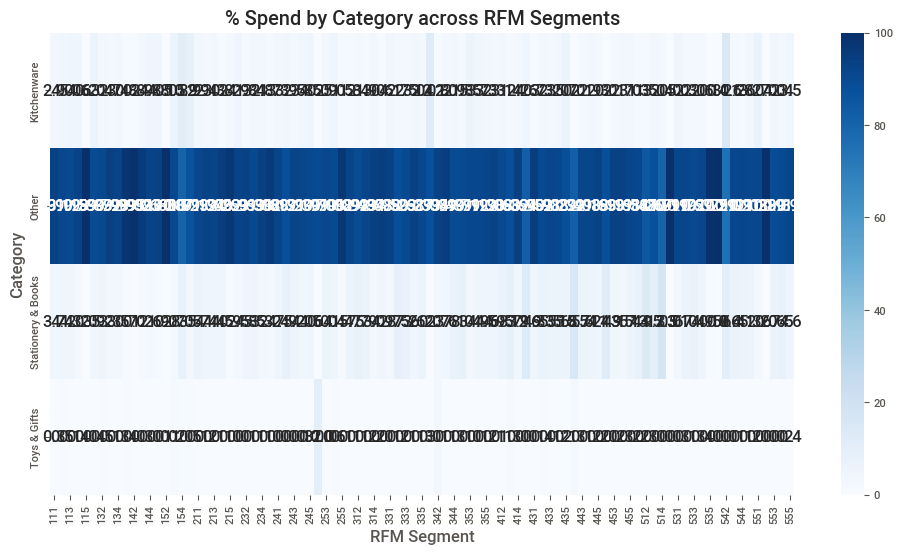

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot percent spend
pivot = (
    segment_category
      .pivot(index='Category', columns='RFM_Segment', values='Pct_Spend')
      .fillna(0)
)

# Draw heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues")
plt.title("% Spend by Category across RFM Segments")
plt.ylabel("Category")
plt.xlabel("RFM Segment")
plt.show()


Highlight Opportunity Gaps
Spot segments under-invested in high-potential categories by comparing spend share to customer penetration:

In [75]:
# Calculate customer penetration per segment/category
segment_category['Cust_Penetration'] = (
    segment_category['Unique_Customers']
      / segment_category.groupby('RFM_Segment')['Unique_Customers']
        .transform('sum')
      * 100
)

# Opportunity = penetration − spend share (positive means under-spent)
segment_category['Opportunity'] = (
    segment_category['Cust_Penetration']
      - segment_category['Pct_Spend']
)

# Top under-leveraged combos
segment_category.sort_values('Opportunity', ascending=False).head(10)


,RFM_Segment,Category,Total_Spent,Unique_Customers,Pct_Spend,Cust_Penetration,Opportunity
122,251,Toys & Gifts,2,1,10.00,50.00,40.00
51,145,Stationery & Books,42,2,1.88,40.00,38.12
256,452,Stationery & Books,48,1,11.94,50.00,38.06
104,241,Kitchenware,32,3,3.27,37.50,34.23
40,142,Kitchenware,3,1,0.77,33.33,32.57
46,144,Kitchenware,283,7,4.78,36.84,32.06
81,215,Kitchenware,388,3,2.16,33.33,31.17
321,551,Stationery & Books,1,1,2.22,33.33,31.11
280,514,Kitchenware,13,1,2.35,33.33,30.98
302,535,Stationery & Books,532,7,0.51,30.43,29.93


Drill Down to SKU Level
Within each segment–category, identify the specific products driving revenue or showing untapped demand:

In [76]:
top_skus = (
    df_rfm_trans
      .groupby(['RFM_Segment','Category','StockCode','Description'])
      .agg(Total_Spent=('Quantity','sum'))
      .reset_index()
      .sort_values(['RFM_Segment','Category','Total_Spent'], ascending=[True,True,False])
)

# View top 5 SKUs per segment & category
top_skus.groupby(['RFM_Segment','Category']).head(5)


,RFM_Segment,Category,StockCode,Description,Total_Spent
13,111,Kitchenware,21399,BLUE POLKADOT COFFEE MUG,102
33,111,Kitchenware,22699,ROSES REGENCY TEACUP AND SAUCER,98
31,111,Kitchenware,22697,GREEN REGENCY TEACUP AND SAUCER,44
15,111,Kitchenware,21845,DAIRY MAID STRIPE MUG,36
21,111,Kitchenware,21876,POTTERING MUG,36
...,...,...,...,...,...
86490,555,Toys & Gifts,20711,JUMBO BAG TOYS,3423
86499,555,Toys & Gifts,22381,TOY TIDY PINK POLKADOT,2514
86491,555,Toys & Gifts,21033,JUMBO BAG CHARLIE AND LOLA TOYS,1632
86498,555,Toys & Gifts,22380,TOY TIDY SPACEBOY,632


Run Association Rules per Segment
Understand cross-sell patterns. Build a basket matrix for each segment and apply Apriori/FP-Growth:

In [77]:
import sys
!{sys.executable} -m pip install --upgrade mlxtend --quiet


In [78]:
from mlxtend.frequent_patterns import apriori, association_rules

# Example: segment “111”
basket_111 = (
    df_rfm_trans[df_rfm_trans['RFM_Segment']=='111']
      .groupby(['InvoiceNo','Description'])['Quantity']
      .sum().unstack().fillna(0).applymap(lambda x: 1 if x>0 else 0)
)

freq_items = apriori(basket_111, min_support=0.02, use_colnames=True)
rules = association_rules(freq_items, metric="lift", min_threshold=1.2)
rules.sort_values('lift', ascending=False).head()


C:\Users\HP\AppData\Local\Temp\ipykernel_4068\2861317852.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .sum().unstack().fillna(0).applymap(lambda x: 1 if x>0 else 0)
C:\Users\HP\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
6,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.03,0.03,0.02,0.64,23.40,1.00,0.02,2.68,0.99,0.54,0.63,0.71
7,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.03,0.03,0.02,0.78,23.40,1.00,0.02,4.35,0.98,0.54,0.77,0.71
3,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT),0.03,0.05,0.02,0.73,15.05,1.00,0.02,3.49,0.97,0.42,0.71,0.61
2,(BAKING SET 9 PIECE RETROSPOT),(BAKING SET SPACEBOY DESIGN),0.05,0.03,0.02,0.50,15.05,1.00,0.02,1.93,0.98,0.42,0.48,0.61
9,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.05,0.03,0.02,0.44,14.71,1.00,0.02,1.75,0.99,0.40,0.43,0.62


In [79]:
strong_rules = rules[
    (rules['support'] >= 0.02) &
    (rules['confidence'] >= 0.60) &
    (rules['lift'] >= 1.5)
].sort_values('lift', ascending=False)


In [80]:
display_rules = (
    strong_rules
      .merge(products[['StockCode','Description','Category']],
             left_on='antecedents', right_on='StockCode', how='left')
      .rename(columns={'Description':'Antecedent_Desc','Category':'Antecedent_Cat'})
      .merge(products[['StockCode','Description','Category']],
             left_on='consequents', right_on='StockCode', how='left')
      .rename(columns={'Description':'Consequent_Desc','Category':'Consequent_Cat'})
)
display(display_rules[['Antecedent_Desc','Consequent_Desc','support','confidence','lift']])


,Antecedent_Desc,Consequent_Desc,support,confidence,lift
0,NaN,NaN,0.02,0.64,23.40
1,NaN,NaN,0.02,0.78,23.40
2,NaN,NaN,0.02,0.73,15.05
3,NaN,NaN,0.02,0.80,14.71
4,NaN,NaN,0.02,0.64,12.39
5,NaN,NaN,0.02,0.89,7.01


In [81]:
# Show overall recency, frequency, monetary stats
rfm[['Recency','Frequency','Monetary']].describe().round(2)


,Recency,Frequency,Monetary
count,4339.00,4339.00,4339.00
mean,92.52,4.60,2452.66
std,100.01,22.94,28086.06
min,1.00,1.00,3.75
25%,18.00,1.00,306.50
50%,51.00,2.00,668.58
75%,142.00,5.00,1660.89
max,374.00,1428.00,1754901.91


In [82]:
_, bin_edges = pd.qcut(
    rfm['Frequency'],
    q=4,
    duplicates='drop',
    retbins=True
)

n_bins = len(bin_edges) - 1
labels = list(range(1, n_bins+1))

rfm['F_Quartile'] = pd.qcut(
    rfm['Frequency'],
    q=4,
    duplicates='drop',
    labels=labels
)


In [83]:
# 1. Create a unique rank for ties
rfm['Freq_Rank'] = rfm['Frequency'].rank(method='first')

# 2. Quartile on the ranks—no duplicates possible now
rfm['F_Quartile'] = pd.qcut(
    rfm['Freq_Rank'],
    q=4,
    labels=[1,2,3,4]
)


In [84]:
# Recency: invert so that smaller days → higher rank
rfm['Rec_Rank'] = rfm['Recency'].rank(method='first', ascending=False)
rfm['R_Quartile'] = pd.qcut(rfm['Rec_Rank'], q=4, labels=[1,2,3,4])

# Monetary
rfm['Mon_Rank'] = rfm['Monetary'].rank(method='first')
rfm['M_Quartile'] = pd.qcut(rfm['Mon_Rank'], q=4, labels=[1,2,3,4])


In [85]:
# Combine into a segment code and score
rfm['RFM_Segment'] = (
    rfm['R_Quartile'].astype(str)
  + rfm['F_Quartile'].astype(str)
  + rfm['M_Quartile'].astype(str)
)
rfm['RFM_Score'] = (
    rfm[['R_Quartile','F_Quartile','M_Quartile']]
    .astype(int)
    .sum(axis=1)
)

# Summarize by segment
segment_summary = (
    rfm
      .groupby('RFM_Segment')
      .agg(
        Count   = ('CustomerID','count'),
        AvgRec  = ('Recency',   'mean'),
        AvgFreq = ('Frequency', 'mean'),
        AvgMon  = ('Monetary',  'mean')
      )
      .round(2)
      .reset_index()
      .sort_values('Count', ascending=False)
)
print(segment_summary.head(10))


   RFM_Segment  Count  AvgRec  AvgFreq   AvgMon
61         444    473    7.07    18.82 12971.97
0          111    301  267.41     1.00   161.06
45         344    225   29.92     9.37  5155.70
4          121    186  255.90     1.25   179.87
1          112    173  256.39     1.00   410.44
41         333    163   30.24     3.35  1057.19
26         233    158   86.85     3.28  1088.69
16         211    147   86.17     1.00   175.30
5          122    130  239.23     1.60   451.46
56         433    128    9.24     3.54  1043.74
